In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import re
import h5py
from six.moves import range

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
%matplotlib inline

In [2]:
from MnvReaderSQLite import MnvCategoricalSQLiteReader

In [3]:
def make_plots_raw(arr, plot_type, colormap='Reds'):
    """
    plots and text for confusion matrices
    """
    fig = plt.figure(figsize=(16,16))
    gs = plt.GridSpec(1, 2)

    def make_title_string(title, logscale):
        title = r'Log$_{10}$ ' + title if logscale else title
        return title
    
    def make_subplot(ax, show_arr, colormap, title):
        im = ax.imshow(show_arr, cmap=plt.get_cmap(colormap), interpolation='nearest', origin='lower')
        cbar = plt.colorbar(im, fraction=0.04)
        plt.title(title)
        plt.xlabel('Softmax probabilties')
        plt.ylabel('Predicted segment')
        
    # linear plots
    ax = plt.subplot(gs[0])
    show_arr = arr
    make_subplot(ax, show_arr, colormap, make_title_string('Probabilities', False))

    # log plots
    ax = plt.subplot(gs[1])
    show_arr = np.log10(arr * 100.0)
    make_subplot(ax, show_arr, colormap, make_title_string('Probabilities', True))
    
    fig.savefig('reco_probabilities_{}.pdf'.format(plot_type), bbox_inches='tight')

In [4]:
def make_diff_plots_raw(arr1, arr2, plot_type, colormap='Reds'):
    """
    plots and text for confusion matrices
    """
    fig = plt.figure(figsize=(16,16))
    gs = plt.GridSpec(1, 2)
    arr = arr1 - arr2

    def make_title_string(title, logscale):
        title = r'Log$_{10}$ ' + title if logscale else title
        return title
    
    def make_subplot(ax, show_arr, colormap, title):
        im = ax.imshow(show_arr, cmap=plt.get_cmap(colormap), interpolation='nearest', origin='lower')
        cbar = plt.colorbar(im, fraction=0.04)
        plt.title(title)
        plt.xlabel('True z-segment')
        plt.ylabel('Reconstructed z-segment')
        
    # linear plots
    ax = plt.subplot(gs[0])
    show_arr = arr
    make_subplot(ax, show_arr, colormap, make_title_string('Differences', False))
    
    #print(np.sum(arr, axis=0))
    
    fig.savefig('differences_raw_{}.pdf'.format(plot_type), bbox_inches='tight')

In [5]:
def make_single_scatters_by_target(arr, plot_type):
    fig = plt.figure(figsize=(16,16))
    gs = plt.GridSpec(2, 3)
    
    idcs = np.arange(67)    
    ids = zip(range(5), [9, 18, 27, 44, 49])
    
    for id in ids:
        ax = plt.subplot(gs[id[0]])
        tmparr = arr[:,id[1]]
        tmparr = tmparr / np.max(tmparr)
        plt.scatter(idcs, tmparr)
        #plt.ylim([-0.001, 0.009])
        
    fig.savefig('single_scatters_by_target_raw_{}.pdf'.format(plot_type), bbox_inches='tight')

In [6]:
def make_scatters_by_target_ratio(arr1, arr2, plot_type):
    idcs = np.arange(67)
    ids = zip(range(5), [9, 18, 27, 44, 49])
    
    fig = plt.figure(figsize=(16,16))
    gs = plt.GridSpec(2, 3)    
    for id in ids:
        ax = plt.subplot(gs[id[0]])
        tmparr1 = arr1[:,id[1]]
        #tmparr1 = tmparr1 / np.max(tmparr1)
        tmparr2 = arr2[:,id[1]]
        #tmparr2 = tmparr2 / np.max(tmparr2)
        tmparr = tmparr1 / tmparr2
        plt.scatter(idcs, tmparr)
        #plt.ylim([-0.001, 0.009])
    
    fig.savefig('single_scatters_by_target_ratio_raw_{}.pdf'.format(plot_type), bbox_inches='tight')

In [7]:
def make_scatters_by_target_same(arr1, arr2, plot_type, label1='MC', label2='Data'):
    idcs = np.arange(67)
    ids = zip(range(5), [9, 18, 27, 44, 49])
            
    fig = plt.figure(figsize=(16,16))
    gs = plt.GridSpec(2, 3)        
    for id in ids:
        ax = plt.subplot(gs[id[0]])
        tmparr1 = arr1[:,id[1]]
        tmparr2 = arr2[:,id[1]]
        plt.scatter(idcs, tmparr1, c='g', label=label1)
        plt.scatter(idcs, tmparr2, c='r', label=label2)
        plt.ylim([0.0, 0.9])
        plt.legend()
        
    fig.savefig('single_scatters_by_target_same_raw_{}.pdf'.format(plot_type), bbox_inches='tight')

In [8]:
DBDIR = '/Users/perdue/Documents/MINERvA/AI/theano/predictions'
MCDB = DBDIR + '/' + 'prediction67_me1Amc_epsilon1480703388'
DATADB = DBDIR + '/' + 'prediction67_me1Adata_epsilon1480703388'

In [9]:
reader_mc = MnvCategoricalSQLiteReader(67, MCDB)
reader_data = MnvCategoricalSQLiteReader(67, DATADB)

In [10]:
reader_mc.get_argmax_prediction(117200, 1, 10, 1)

6

In [11]:
reader_mc.read_record(117200, 1, 10, 1)

[(1, 117200, 1, 10, 1, 6, 0.00010858808746480794, 0.0004287932533767384, 0.0015524554530774212, 0.005482828128914863, 0.016857968796242368, 0.2544161927647897, 0.7117803909446575, 0.00796995256240546, 0.0005517380631912177, 0.0008489131312961546, 9.419049285215235e-07, 3.8265340213402475e-08, 5.205979812620605e-07, 1.12427307957966e-08, 4.55437073585158e-09, 4.350692758784501e-09, 9.48631790016438e-09, 4.4599847907364623e-10, 4.259771302895573e-09, 8.729227451698596e-10, 2.753935000153996e-10, 4.876233603421149e-10, 9.072048333062541e-11, 3.8148553895762187e-11, 2.349400835027777e-11, 8.18706694275834e-11, 1.603637846974013e-09, 9.985316884596106e-10, 2.369906150322548e-10, 4.127236650923951e-10, 3.012992918809576e-08, 5.122654501151177e-08, 6.049002989270802e-09, 4.838851910989585e-10, 6.025132712347433e-10, 4.0407846644239997e-10, 4.4626635621357363e-10, 4.1093250766220205e-09, 3.5659373237147307e-08, 1.2891687566676341e-08, 3.2708854264995303e-10, 6.798519021154429e-11, 4.3146019380

In [12]:
reader_mc.read_record_by_id(1)

[(1, 117200, 1, 10, 1, 6, 0.00010858808746480794, 0.0004287932533767384, 0.0015524554530774212, 0.005482828128914863, 0.016857968796242368, 0.2544161927647897, 0.7117803909446575, 0.00796995256240546, 0.0005517380631912177, 0.0008489131312961546, 9.419049285215235e-07, 3.8265340213402475e-08, 5.205979812620605e-07, 1.12427307957966e-08, 4.55437073585158e-09, 4.350692758784501e-09, 9.48631790016438e-09, 4.4599847907364623e-10, 4.259771302895573e-09, 8.729227451698596e-10, 2.753935000153996e-10, 4.876233603421149e-10, 9.072048333062541e-11, 3.8148553895762187e-11, 2.349400835027777e-11, 8.18706694275834e-11, 1.603637846974013e-09, 9.985316884596106e-10, 2.369906150322548e-10, 4.127236650923951e-10, 3.012992918809576e-08, 5.122654501151177e-08, 6.049002989270802e-09, 4.838851910989585e-10, 6.025132712347433e-10, 4.0407846644239997e-10, 4.4626635621357363e-10, 4.1093250766220205e-09, 3.5659373237147307e-08, 1.2891687566676341e-08, 3.2708854264995303e-10, 6.798519021154429e-11, 4.3146019380

In [13]:
reader_mc.read_record_by_id(1)[0][0:6]

(1, 117200, 1, 10, 1, 6)

In [14]:
n_classes = len(reader_mc.read_record_by_id(1)[0][6:])
print(n_classes)

67


In [15]:
np.sum(reader_mc.read_record_by_id(1)[0][6:])

1.0

In [16]:
n_evt = 300000

/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in divide
/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in divide


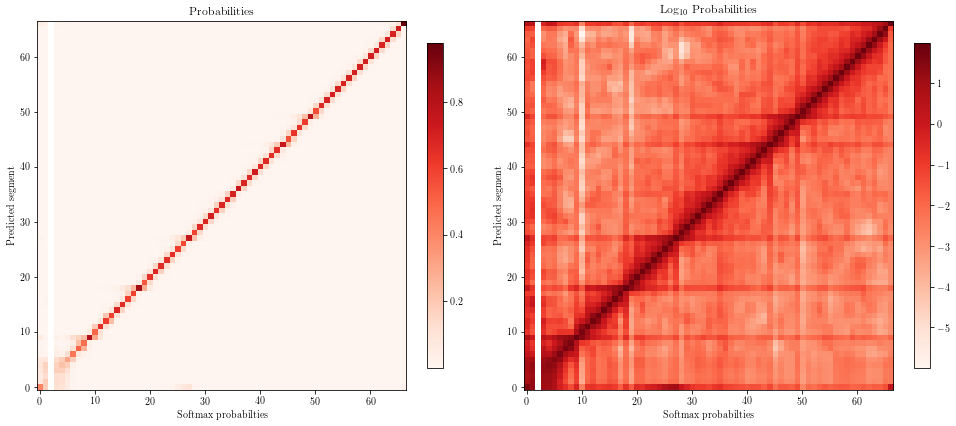

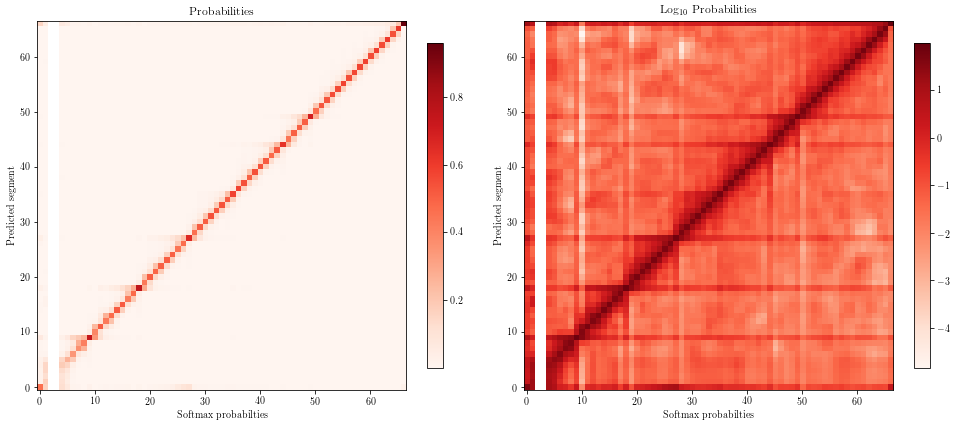

In [17]:
results_mc = np.zeros((n_classes, n_classes))

#sqlite> select count(*) from zsegment_prediction;
#6661231
#sqlite> select max(id) from zsegment_prediction;
#6661231

for i in range(n_evt):
    id = i + 1
    fetched = reader_mc.read_record_by_id(id)[0]
    segment = fetched[5]
    results_mc[:,segment] += fetched[6:]
    
n_pred_mc = np.zeros(n_classes)
for i in range(n_classes):
    s = np.sum(results_mc[:,i])
    n_pred_mc[i] = s
    results_mc[:,i] = results_mc[:,i] / s

make_plots_raw(results_mc, 'mc')

results_data = np.zeros((67, 67))

#sqlite> select max(id) from zsegment_prediction;
#957109

for i in range(n_evt):
    id = i + 1
    fetched = reader_data.read_record_by_id(id)[0]
    segment = fetched[5]
    results_data[:,segment] += fetched[6:]
    
n_pred_data = np.zeros(n_classes)
for i in range(n_classes):
    s = np.sum(results_data[:,i])
    n_pred_data[i] = s
    results_data[:,i] = results_data[:,i] / s

make_plots_raw(results_data, 'data')

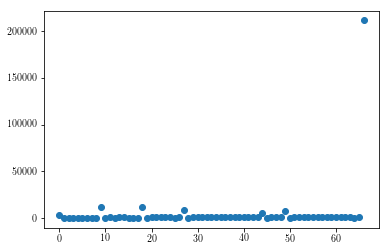

In [18]:
plt.scatter(np.arange(n_classes), n_pred_data)

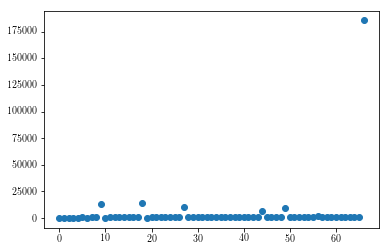

In [19]:
plt.scatter(np.arange(n_classes), n_pred_mc)

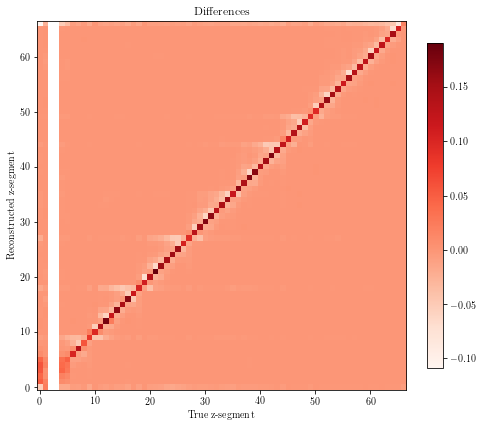

In [20]:
make_diff_plots_raw(results_mc, results_data, 'mc_minus_data')

Max probability normalized vectors for the events that had the targets as their max softmax value for MC:

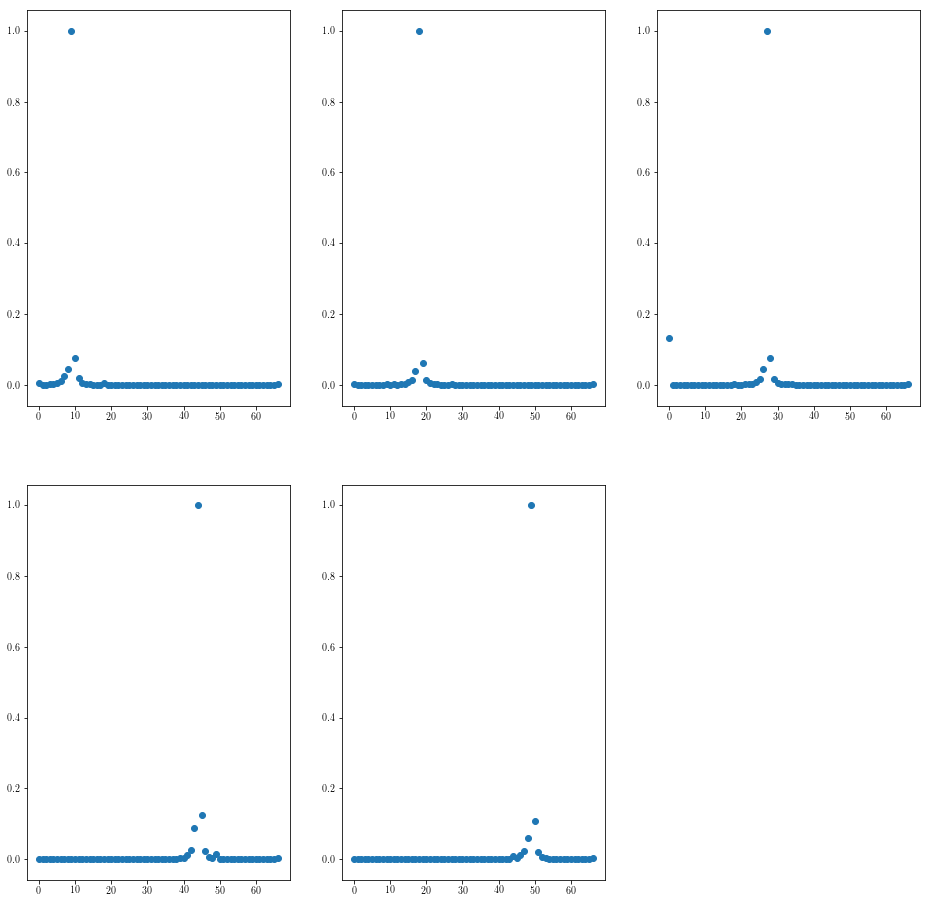

In [21]:
make_single_scatters_by_target(results_mc, 'mc')

Max probability normalized vectors for the events that had the targets as their max softmax value for data:

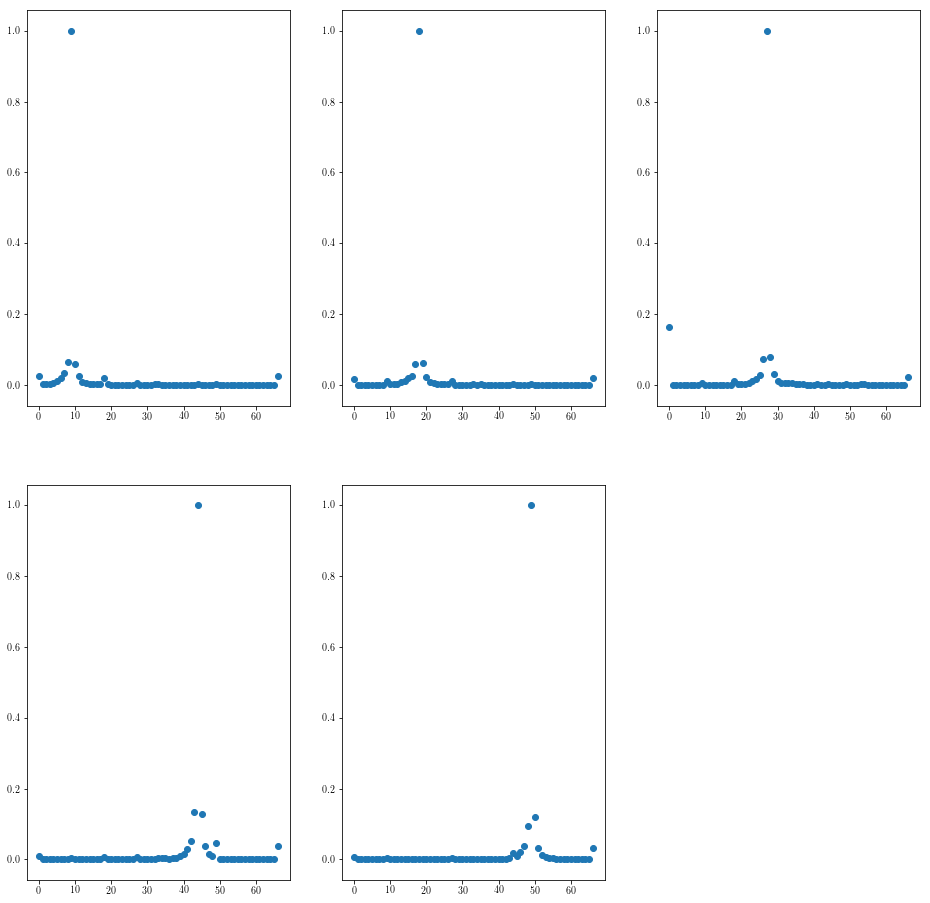

In [22]:
make_single_scatters_by_target(results_data, 'data')

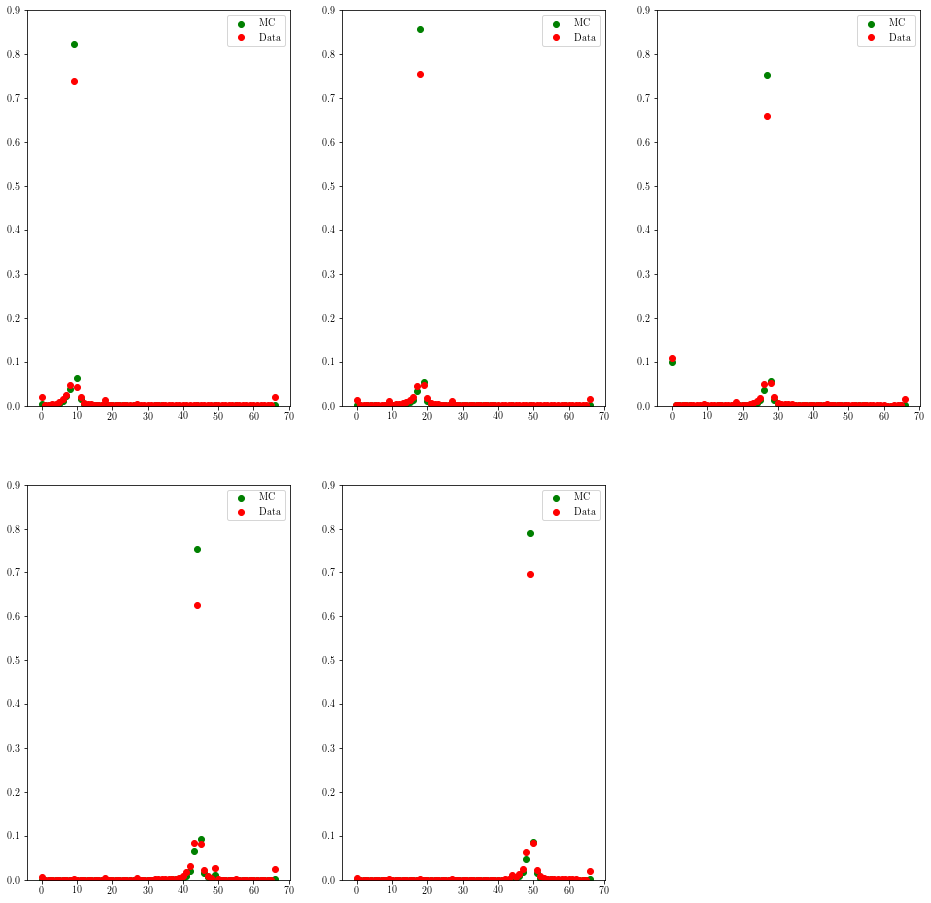

In [23]:
make_scatters_by_target_same(results_mc, results_data, 'scatters')

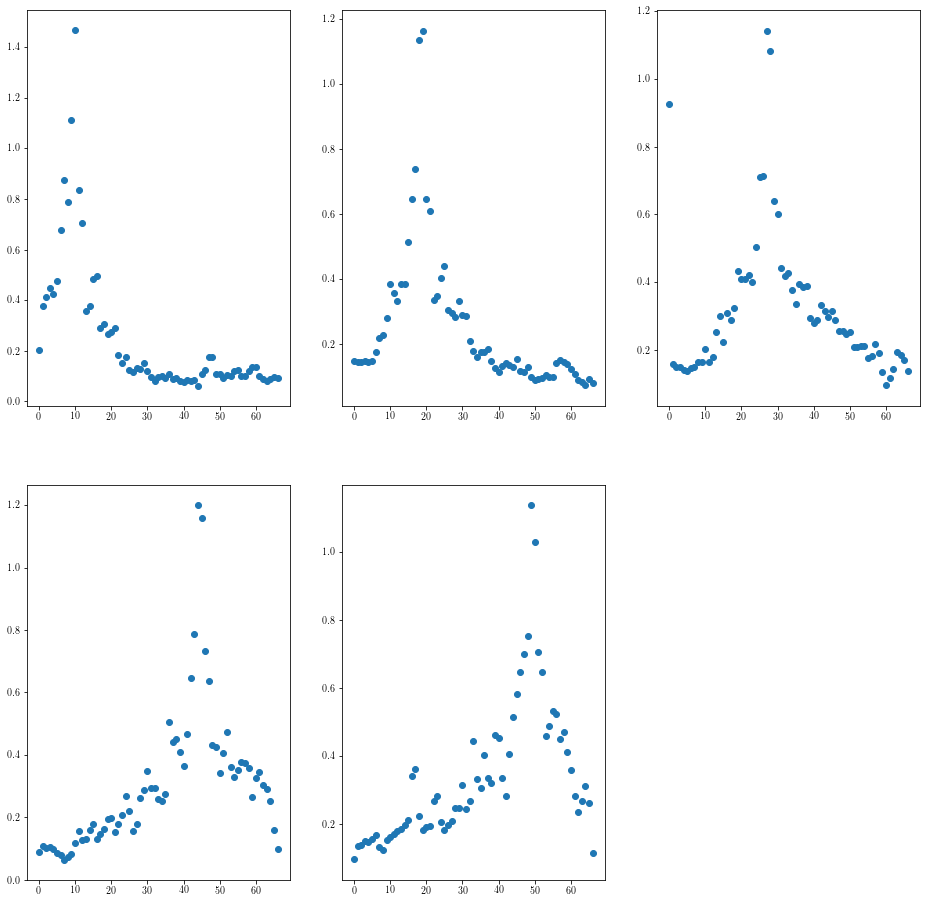

In [24]:
make_scatters_by_target_ratio(results_mc, results_data, 'scatters')

In [25]:
a = (results_mc - results_data)**2
a_s = np.sum(a, axis=0)
print(a_s)

[ 0.02805592  0.00225531         nan         nan  0.00834098  0.00650472
  0.01237425  0.0222804   0.00425853  0.00822827  0.01410632  0.02368311
  0.03756103  0.01700761  0.03076999  0.0243965   0.03407645  0.01713505
  0.01132616  0.01726406  0.02108467  0.04197362  0.02717184  0.02426062
  0.02815582  0.0300967   0.01304744  0.00942175  0.02142698  0.0271642
  0.03506387  0.03115166  0.01898135  0.02384322  0.02883795  0.01501679
  0.03074999  0.02195763  0.03489734  0.03128915  0.02085803  0.02715363
  0.03662004  0.02243556  0.01741789  0.0136087   0.02202721  0.02415089
  0.01417678  0.00989389  0.01202242  0.02178826  0.03089429  0.02580794
  0.02049565  0.01422236  0.02951092  0.02057181  0.0192968   0.01813168
  0.02879705  0.01614168  0.01930095  0.01242779  0.02924074  0.01896417
  0.00037933]


In [26]:
a_s = a_s / (1/n_pred_mc + 1/n_pred_data)
a_s_real = a_s[~np.isnan(a_s)]
print(a_s_real)
print(np.sum(a_s_real))

[  1.08574521e+01   1.50353884e-03   2.63771103e-01   1.36893795e+00
   8.40039061e-01   4.66827423e+00   1.08412091e+00   5.10702309e+01
   1.60812050e-01   9.84533827e+00   1.06371745e+01   8.08012529e+00
   1.37412389e+01   8.76633127e+00   8.38232079e+00   4.71461048e+00
   7.48233616e+01   1.42586408e+00   8.41317150e+00   1.66094945e+01
   1.27885509e+01   1.14795049e+01   1.12534054e+01   1.04178244e+01
   5.63202788e+00   4.43347138e+01   5.15378422e+00   1.31953055e+01
   1.42714436e+01   1.60818283e+01   9.60693505e+00   1.12005148e+01
   1.34460814e+01   8.86611061e+00   1.62641695e+01   1.13789803e+01
   1.51993638e+01   1.70516531e+01   1.18127222e+01   1.20569899e+01
   1.53964770e+01   1.00311091e+01   5.30148768e+01   3.03190686e+00
   9.24754784e+00   9.90872296e+00   5.50175942e+00   4.01224742e+01
   2.66784784e+00   1.10231028e+01   1.37808727e+01   1.42567004e+01
   1.18878343e+01   7.57499027e+00   1.58045811e+01   1.14964518e+01
   1.11638288e+01   9.54114509e+00

/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in divide
  """Entry point for launching an IPython kernel.


In [29]:
np.sum(results_mc[:,9])

1.0000000000000002

In [30]:
np.sum(results_data[:,9])

1.0